In [6]:
#Loads some parameters
import CloudDataset128f
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import torchvision.transforms.v2 as v2
from PIL import Image
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
import torch.optim as optim
batch_size = 8

#imports state of the art model.
#model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50')
print("Load successfull")


Load successfull


<class 'torch.Tensor'>
torch.Size([8, 12, 128, 128])
torch.Size([8, 4, 128, 128])


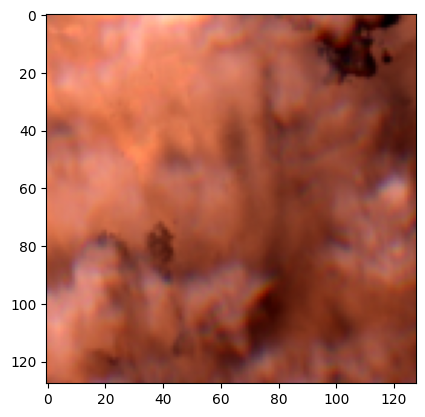

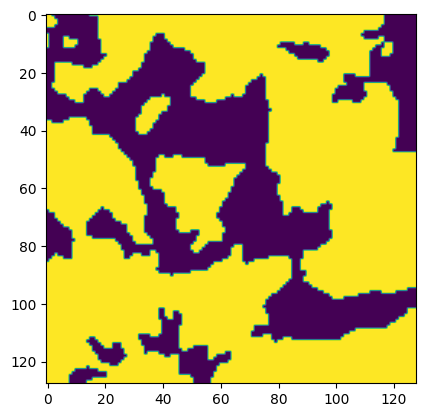

In [7]:
transform = {
    "image": v2.Compose([
    transforms.Resize(size=(256,256)),
]),
    "mask": v2.Compose([
    transforms.Resize(size=(256,256)),
])}

# Get the dataset of the CloudDataset
dataset = CloudDataset128f.CloudDataset("data\\train",transform=transform)

# Creates validation/training dataset with 20/80 split
validation_dataset, training_dataset = torch.utils.data.random_split(dataset,[0.2, 0.8])

# Create a DataLoaders from the datasets.
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)

# Creates an iterator and plots the pictures
it = iter(training_loader)
images, labels = next(it)

print(type(images))
print(images.shape)
print(labels.shape)

plt.figure()
plt.imshow(images[0][:3].permute(1,2,0))
plt.show()

plt.figure()
i=2
plt.imshow(labels[0][i:i+1].permute(1,2,0))
plt.show()

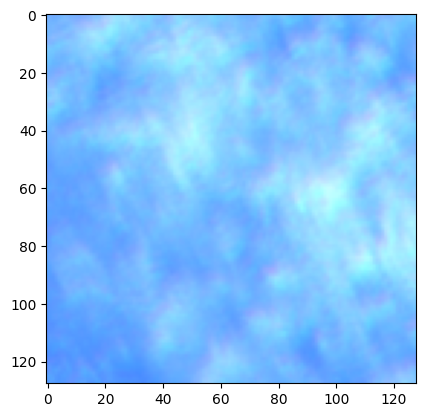

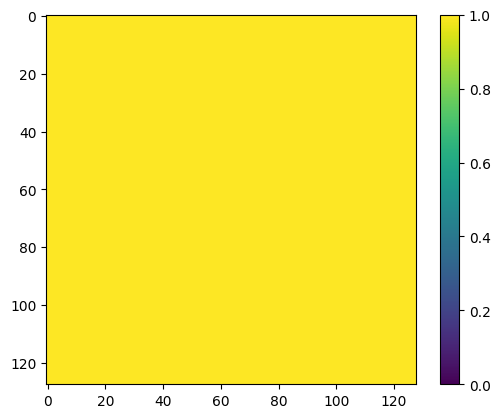

In [3]:
# Grabs next bath of pictures and displays the first, run multiple times for different plots
images, labels = next(it)

plt.figure()
plt.imshow(images[0][:3].permute(1,2,0))
plt.show()

plt.figure()
i=2
img = plt.imshow(labels[0][i:i+1].permute(1,2,0),vmin=0,vmax=1)
plt.colorbar(img)
plt.show()

In [4]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 128x128x12
        self.e11 = nn.Conv2d(12, 64, kernel_size=3, padding=1) # output: 128x128x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 128x128x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 64x64x64

        # input: 64x64x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 64x64x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 64x64x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x128

        # input: 32x32x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 32x32x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 32x32x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 16x16x256

        # input: 16x16x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 16x16x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 16x16x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 8x8x512

        # input: 8x8x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 8x8x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 8x8x1024
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 4x4x1024

        # input: 4x4x1024
        self.e61 = nn.Conv2d(1024, 2048, kernel_size=3, padding=1) # output: 4x4x2048
        self.e62 = nn.Conv2d(2048, 2048, kernel_size=3, padding=1) # output: 4x4x2048


        # Decoder
        # input: 4x4x2048
        self.upconv0 = nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2) # output: 8x8x2048
        self.d01 = nn.Conv2d(2048, 1024, kernel_size=3, padding=1) # output: 8x8x1024
        self.d02 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 8x8x1024


        # input: 8x8x1024
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2) # output: 16x16x1024
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1) # output: 16x16x512
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 16x16x512

        # input: 16x16x512
        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2) # output: 32x32x512
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1) # output: 32x32x256
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 32x32x256

        # input: 32x32x256
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) # output: 64x64x256
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1) # output: 64x64x128
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 64x64x128

        # input: 64x64x128
        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2) # output: 128x128x128
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1) # output: 128x128x64
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 128x128x64

        # Output layer
        # input: 128x128x64
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1) # output: 128 x 128 x n_class

        #Dropout
        self.dropout = nn.Dropout(0.85)
    
    def forward(self, x):
        # Encoder
        #print(x.shape)
        xe11 = relu(self.e11(x))
        #print(xe11.shape)
        xe12 = relu(self.e12(xe11))
        #print(xe12.shape)
        xp1 = self.pool1(xe12)
        #print(xp1.shape)

        xe21 = relu(self.e21(xp1))
        #print(xe21.shape)
        xe22 = relu(self.e22(xe21))
        #print(xe22.shape)
        xp2 = self.pool2(xe22)
        #print(xp2.shape)

        xe31 = relu(self.e31(xp2))
        #print(xe31.shape)
        xe32 = relu(self.e32(xe31))
        #print(xe32.shape)
        xp3 = self.pool3(xe32)
        #print(xp3.shape)

        xe41 = relu(self.e41(xp3))
        #print(xe41.shape)
        xe42 = relu(self.e42(xe41))
        #print(xe42.shape)
        xp4 = self.pool4(xe42)
        #print(xp4.shape)

        xe51 = relu(self.e51(xp4))
        #print(xe51.shape)
        xe52 = relu(self.e52(xe51))
        #print(xe52.shape)
        xp5 = self.pool5(xe52)
        #print(xp5.shape)

        xe61 = relu(self.e61(xp5))
        #print(xe51.shape)
        xe62 = relu(self.e62(xe61))
        #print(xe52.shape)
        
        # Decoder
        xu0 = self.upconv0(xe62)
        xu01 = torch.cat([xu0, xe52], dim=1)
        xd01 = relu(self.d01(xu01))
        xd02 = relu(self.d02(xd01))

        xu1 = self.upconv1(xd02)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out=self.outconv(xd42)

        return out

Epoch: 0 batch_nr: 0 Time: 3.8731702999793924 Time_diff: 3.8731718999915756 loss: 1.9411386251449585
Epoch: 0 batch_nr: 8 Time: 78.37309300000197 Time_diff: 8.196886099991389 loss: 18.408353249231975

 New best loss: 1.8824742237726848


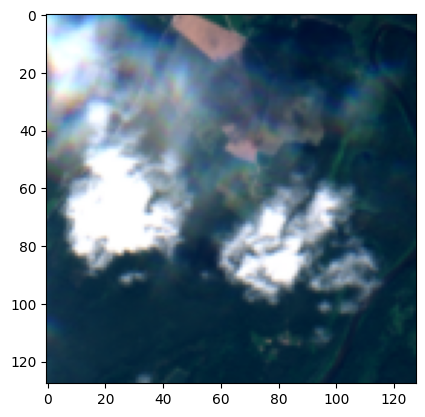

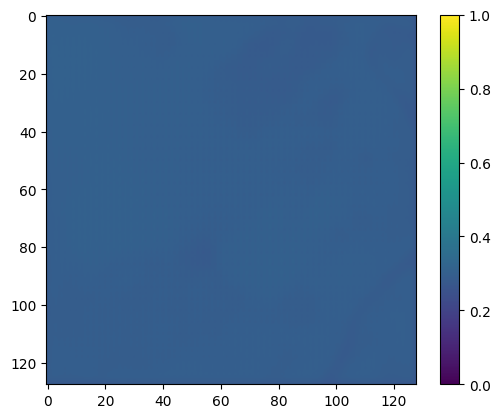

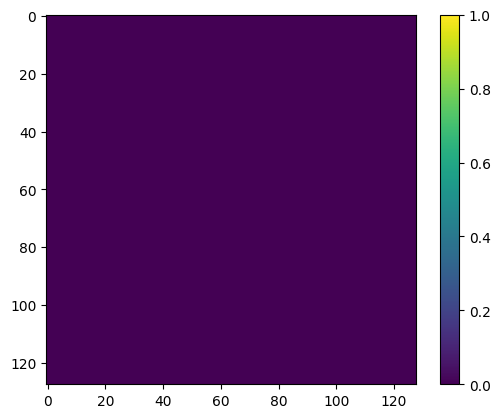

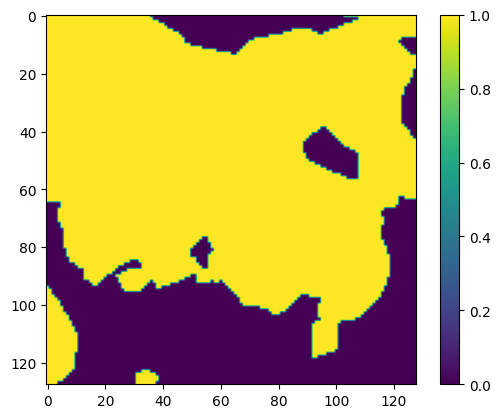

Epoch: 1 batch_nr: 7 Time: 160.7236931999796 Time_diff: 8.40498540000408 loss: 1.979413628578186

 New best loss: 1.361712376276652


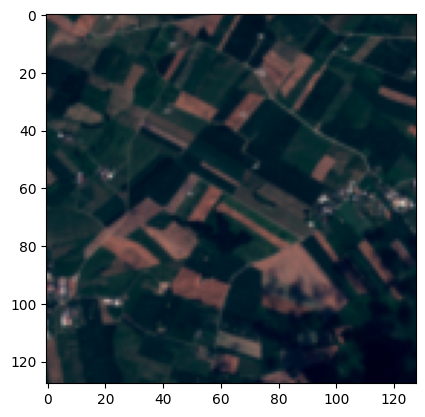

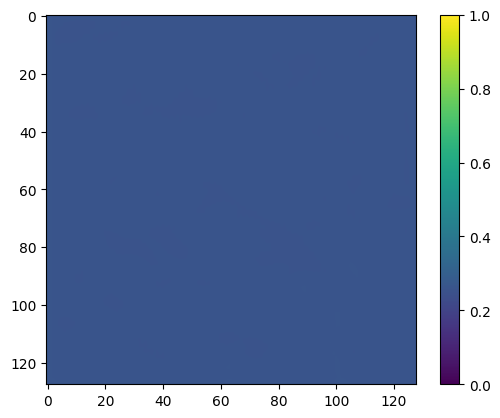

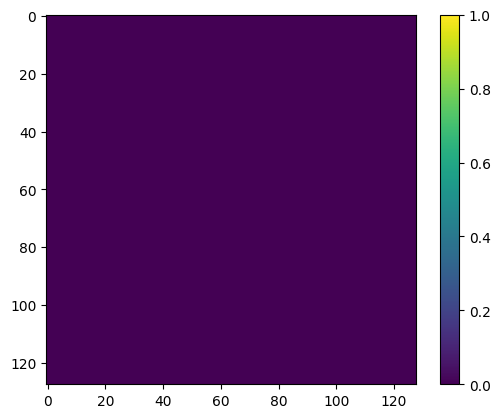

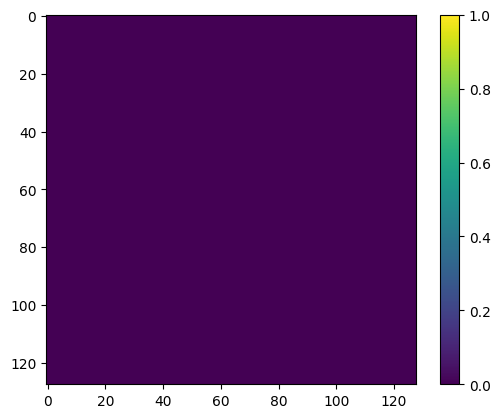

Epoch: 2 batch_nr: 6 Time: 242.7196187999798 Time_diff: 9.460064899991266 loss: 2.082933851650783
new val loss: 1.6198938687642415
Epoch: 3 batch_nr: 5 Time: 331.06149059999734 Time_diff: 8.215159700019285 loss: 1.603125810623169
new val loss: 1.5100691119829814
Epoch: 4 batch_nr: 4 Time: 405.22867439998663 Time_diff: 8.280207900010282 loss: 1.5959073781967164
new val loss: 1.3890681266784668
Epoch: 5 batch_nr: 3 Time: 480.00638809998054 Time_diff: 8.248174600012135 loss: 1.5555430948734283

 New best loss: 0.9027886589368185


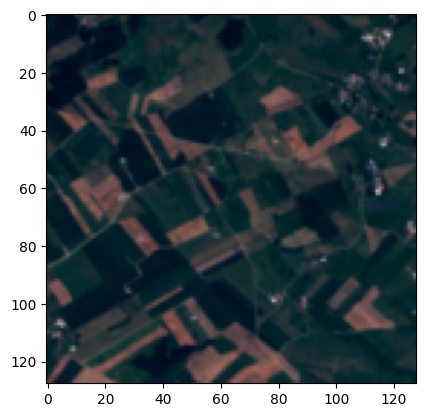

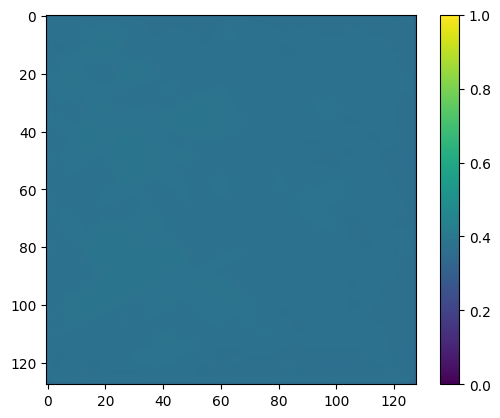

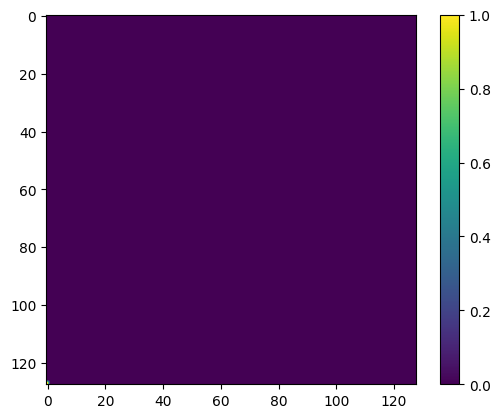

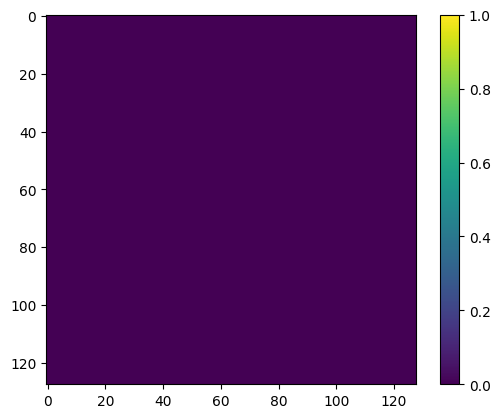

Epoch: 6 batch_nr: 2 Time: 558.8958895999822 Time_diff: 8.3317199999874 loss: 0.88643346230189
new val loss: 1.0000898440678914
Epoch: 7 batch_nr: 1 Time: 635.2367145000026 Time_diff: 8.302653299993835 loss: 1.0231022238731384

 New best loss: 0.8236408034960429


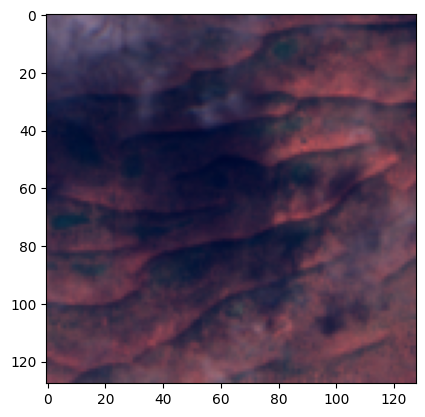

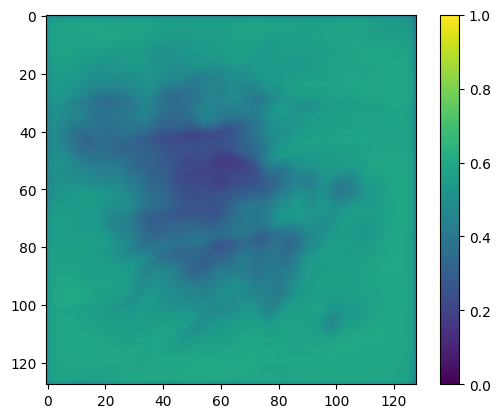

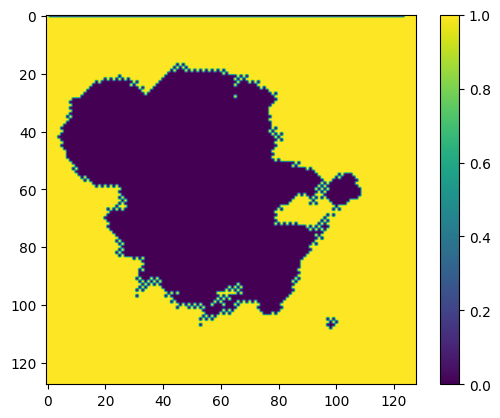

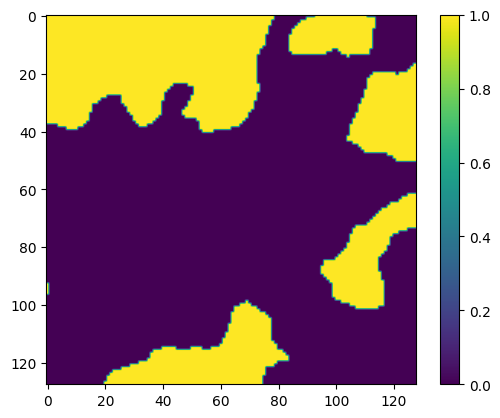

Epoch: 8 batch_nr: 0 Time: 712.7634598999866 Time_diff: 19.8399594000075 loss: 0.8725565075874329
Epoch: 8 batch_nr: 8 Time: 778.5419639000029 Time_diff: 7.661002299981192 loss: 0.8459818230734931
new val loss: 0.9021237293879191
Epoch: 9 batch_nr: 7 Time: 854.5088699999906 Time_diff: 8.135794200003147 loss: 0.9735583737492561

 New best loss: 0.7630226810773214


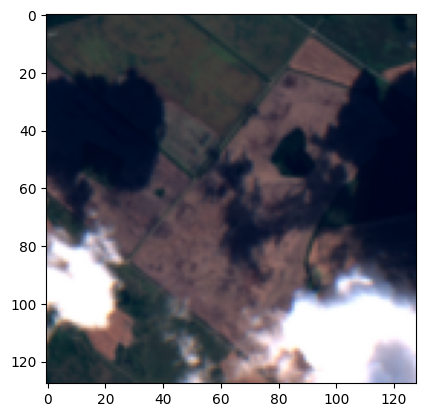

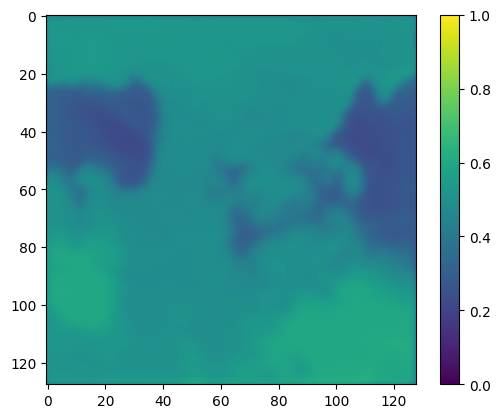

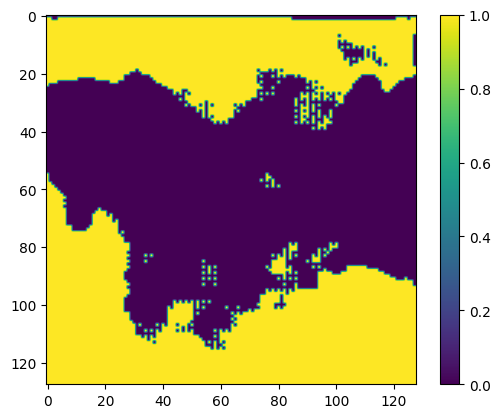

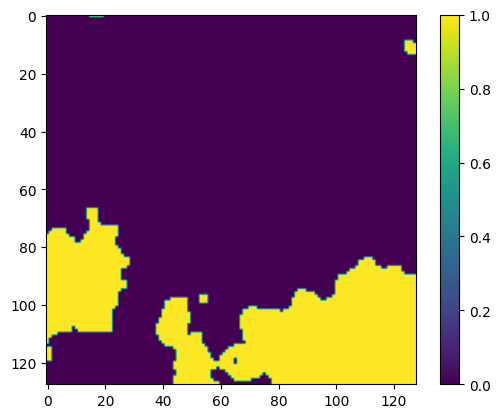

Epoch: 10 batch_nr: 6 Time: 931.2545071999775 Time_diff: 8.115665599994827 loss: 0.8638684834752764
new val loss: 0.7699599862098694
Epoch: 11 batch_nr: 5 Time: 1007.9017991999863 Time_diff: 8.514421800005948 loss: 0.9058881103992462

 New best loss: 0.687491774559021


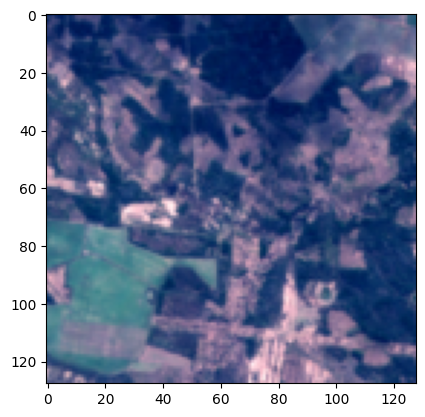

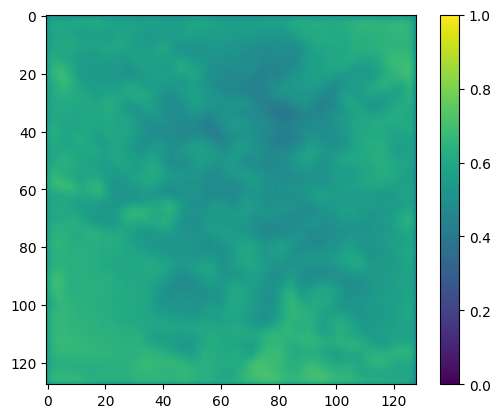

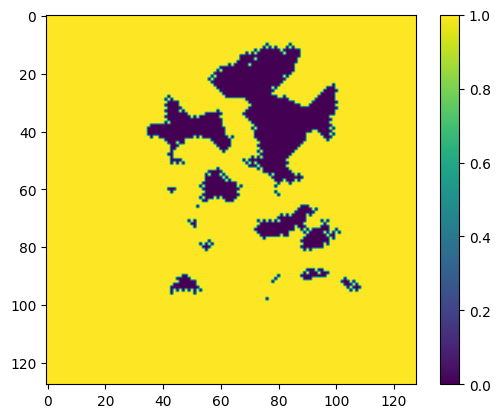

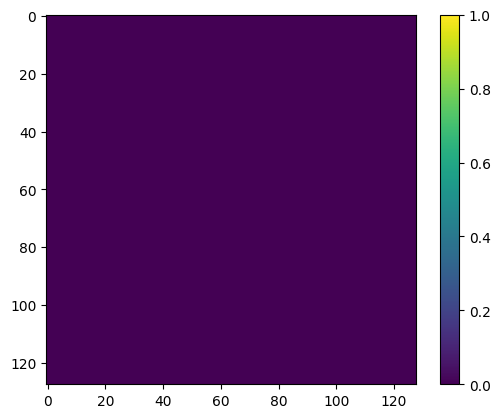

Epoch: 12 batch_nr: 4 Time: 1128.2610280999797 Time_diff: 10.357957800006261 loss: 0.7196622848510742

 New best loss: 0.6487023333708445


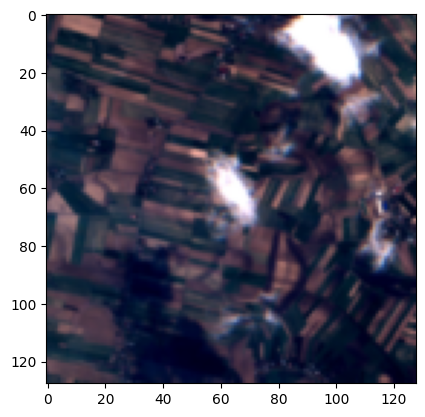

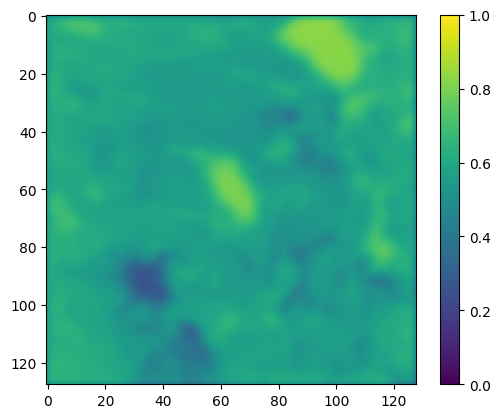

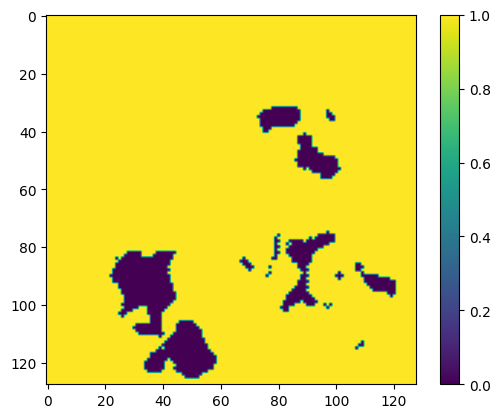

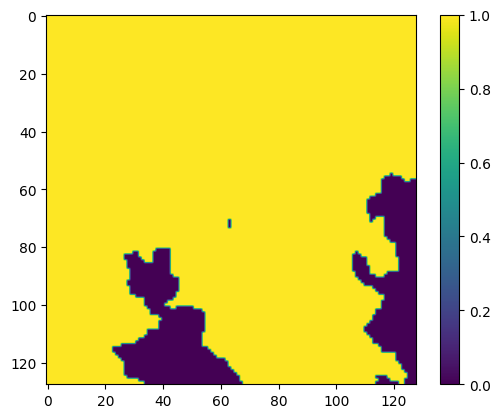

Epoch: 13 batch_nr: 3 Time: 1246.8701047999784 Time_diff: 10.426556499995058 loss: 0.7469180077314377
new val loss: 0.6719018916289011
Epoch: 14 batch_nr: 2 Time: 1344.267900899984 Time_diff: 9.981565200025216 loss: 0.8677190542221069
new val loss: 0.6906524697939554
Epoch: 15 batch_nr: 1 Time: 1434.1967553999857 Time_diff: 11.849315700004809 loss: 0.7283062636852264


KeyboardInterrupt: 

In [10]:
import copy
from time import perf_counter

epochs=500

def train_model(train_loader, val_loader, model, criterion, optimizer, scheduler):
    start_time = perf_counter()
    time = 0


    best_loss = float('inf')

    train_loss = []
    val_loss = []
    for epoch in range(epochs):
        avg_loss_list = []
        for batch_nr, (images,labels) in enumerate(train_loader):
            #Forward pass
            predictions = model(images)
            loss = criterion(predictions,labels.float())
            avg_loss_list.append(loss.item())
            
            if((batch_nr+epoch)%8==0):
                print("Epoch:",epoch,"batch_nr:",batch_nr,"Time:",perf_counter()-start_time,"Time_diff:",perf_counter()-start_time-time,"loss:",(sum(avg_loss_list)/len(avg_loss_list)))
            time=perf_counter()-start_time

            #Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update learning rate
            scheduler.step()
        

        avg_v_loss_list = []
        for batch_nr, (images_valid,labels_valid) in enumerate(val_loader):
            predictions = model(images_valid)
            loss = criterion(predictions,labels_valid.float())
            avg_v_loss_list.append(loss.item())

        train_loss.append((sum(avg_loss_list)/len(avg_loss_list)))
        val_loss.append((sum(avg_v_loss_list)/len(avg_v_loss_list)))

        #Finds best model
        if (val_loss[-1]<best_loss):
            best_loss=val_loss[-1]
            best_model = copy.deepcopy(model)
            torch.save(model, 'best_UNET128f_model.pt')
            print("\n New best loss:",best_loss)

            
            plt.figure()
            plt.imshow(images_valid[0][:3].permute(1,2,0))
            plt.show()
            
            i=2

            predictions_softmax = nn.Softmax(dim=1)(predictions.detach())

            plt.figure()
            img=plt.imshow(predictions_softmax[0][i:i+1][:3].permute(1,2,0),vmin=0, vmax=1)
            plt.colorbar(img)
            plt.show()

            a = predictions_softmax.argmax (1)
            predictions_binary = torch.zeros(predictions_softmax.shape).scatter (1, a.unsqueeze (1), 1.0)

            plt.figure()
            img=plt.imshow(predictions_binary[0][i:i+1].permute(1,2,0),vmin=0, vmax=1)
            plt.colorbar(img)
            plt.show()


            plt.figure()
            img=plt.imshow(labels_valid[0][i:i+1].permute(1,2,0),vmin=0, vmax=1)
            plt.colorbar(img)
            plt.show()
        else:
            print("new val loss:",val_loss[-1])
    
    plt.plot(range(1,epochs+1),train_loss, color='r', label='losses')
    plt.plot(range(1,epochs+1),val_loss, color='g', label='losses_valid')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    return best_model

    

model = UNet(4)
optimizer = optim.Adam(model.parameters(),lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.9)
criterion = nn.CrossEntropyLoss(weight=torch.Tensor([1, 1.0, 1.1012984489652178, 9.963196923922]))

best_model=train_model(training_loader,validation_loader,model,criterion,optimizer,scheduler)


In [17]:
def from_one_hot(label):
    return np.argmax(label,0,keepdims=True)

test_dataset = CloudDataset128f.CloudDataset("data\\train",transform=transform)
batch_size=1
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
test_it = iter(test_loader)
best_model = torch.load("best_UNET128f_model.pt")
criterion = nn.CrossEntropyLoss()
predictions = best_model(images)

In [15]:
it = iter(test_loader)

In [12]:
images,labels = next(test_it)
predictions = best_model(images)

In [16]:
a = torch.rand(size=(2,2))
b = a-torch.ones(size=(2,2))*0.5
print(a)
print(b)

tensor([[0.4031, 0.6917],
        [0.6175, 0.0103]])
tensor([[-0.0969,  0.1917],
        [ 0.1175, -0.4897]])


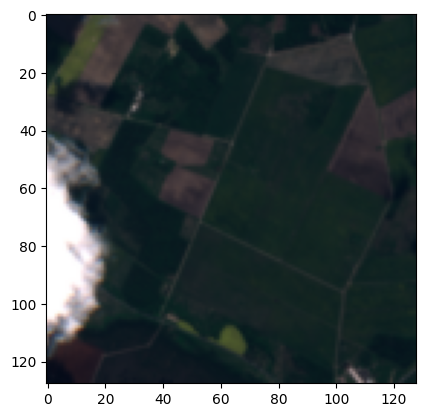

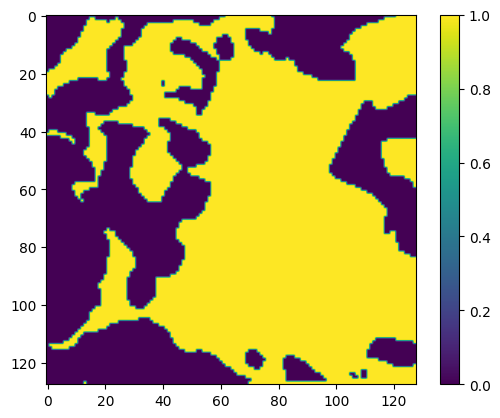

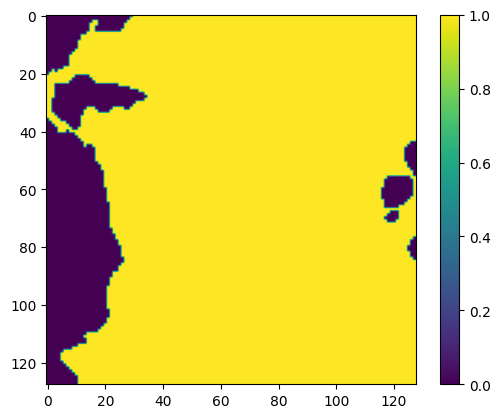

loss: tensor(1.2684, grad_fn=<DivBackward1>)


In [14]:

plt.figure()
plt.imshow(images[0][:3].permute(1,2,0))
plt.show()
i=1

predictions_softmax = nn.Softmax(dim=1)(predictions.detach())
a = predictions_softmax.argmax (1)
predictions_binary = torch.zeros (predictions_softmax.shape).scatter (1, a.unsqueeze (1), 1.0)

plt.figure()
img=plt.imshow(predictions_binary[0][i:i+1].permute(1,2,0),vmin=0, vmax=1)
plt.colorbar(img)
plt.show()

plt.figure()
img=plt.imshow(from_one_hot(labels[0]).permute(1,2,0),vmin=0, vmax=5)
plt.colorbar(img)
plt.show()

print("loss:",criterion(predictions,labels.float()))

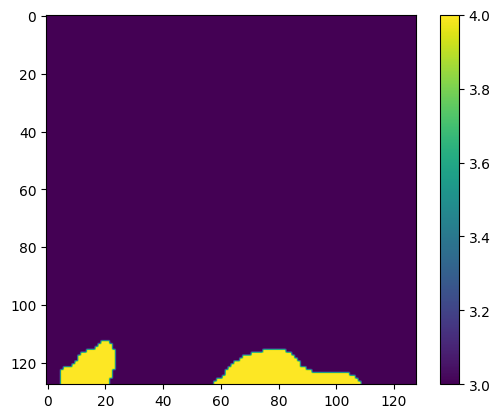

In [10]:


l = (from_one_hot(labels[0]))

plt.figure()
img=plt.imshow(l.permute(1,2,0))
plt.colorbar(img)
plt.show()

In [35]:
images,labels = next(test_it)
predictions = best_model(images)

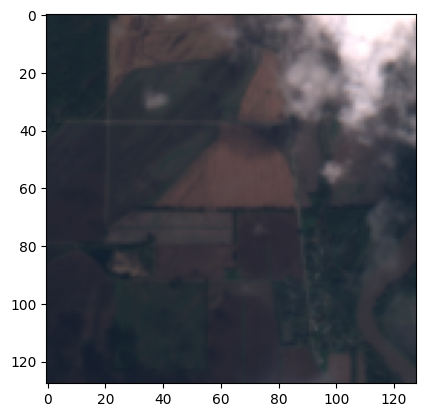

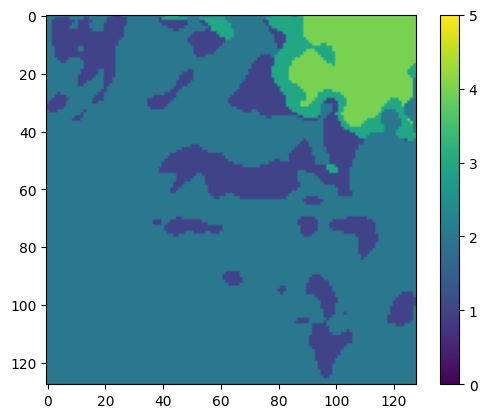

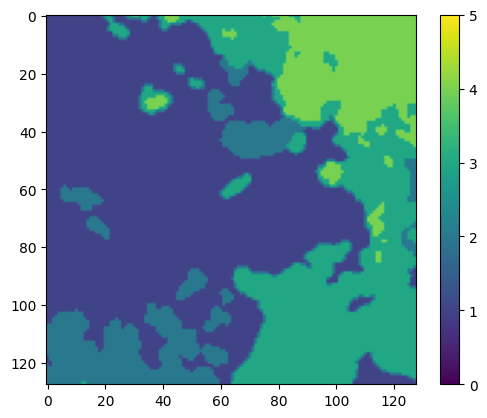

loss: tensor(1.1232, grad_fn=<DivBackward1>)


In [18]:
images,labels = next(test_it)
predictions = best_model(images)

plt.figure()
plt.imshow(images[0][:3].permute(1,2,0))
plt.show()

predictions_softmax = nn.Softmax(dim=1)(predictions.detach())
a = predictions_softmax.argmax (1)
predictions_binary = torch.zeros (predictions_softmax.shape).scatter (1, a.unsqueeze (1), 1.0)

plt.figure()
img=plt.imshow(from_one_hot(predictions_binary[0]).permute(1,2,0),vmin=0, vmax=5)
plt.colorbar(img)
plt.show()


plt.figure()
img=plt.imshow(from_one_hot(labels[0]).permute(1,2,0),vmin=0, vmax=5)
plt.colorbar(img)
plt.show()

print("loss:",criterion(predictions,labels.float()))

In [63]:
_,labels = next(iter(training_loader))

In [8]:

vs = [0,0,0,0,0,0]
total=0
for batch_nr, (_,labels) in enumerate(training_loader):
    for label in labels:
        i=0
        while i<4:
            sum = torch.sum(label[i:i+1]).item()
            vs[i]+=sum
            total+=sum
            i+=1
for batch_nr, (_,labels) in enumerate(validation_loader):
    for label in labels:
        i=0
        while i<4:
            sum = torch.sum(label[i:i+1]).item()
            vs[i]+=sum
            total+=sum
            i+=1
print(vs)
m = max(vs)
for i, e in enumerate(vs):
    try:
        vs[i]=m/e
    except:
        vs[i]=0
print(vs)

[1050, 725520, 658786, 72820, 0, 0]
[690.9714285714285, 1.0, 1.1012984489652178, 9.963196923922, 0, 0]


In [18]:
#Evaluate
total = 0
correct = 0

for batch_nr, (images, labels) in enumerate(test_loader):

    predictions = best_model(images)

    predictions_softmax = nn.Softmax(dim=1)(predictions.detach())
    predictions_binary = torch.zeros(predictions_softmax.shape).scatter (1, predictions_softmax.argmax(1).unsqueeze(1), 1.0)

    i=0
    while i<len(predictions):
        pred = from_one_hot(predictions_binary[i])
        label = from_one_hot(labels[i])

        y = torch.sum((pred==label))
        correct += y
        total += 128*128
        i+=1

print("Accuracy =", correct/total)

    

Accuracy = tensor(0.5578)


In [19]:
# IoU calculation

Union = [0,0,0,0,0,0] 
Intersection = [0,0,0,0,0,0]

for batch_nr, (images, labels) in enumerate(test_loader):

    predictions = best_model(images)

    predictions_softmax = nn.Softmax(dim=1)(predictions.detach())
    predictions_binary = torch.zeros(predictions_softmax.shape).scatter (1, predictions_softmax.argmax(1).unsqueeze(1), 1.0)

    i=0
    while i<len(predictions):
        pred = from_one_hot(predictions_binary[i])
        label = from_one_hot(labels[i])

        for p_class in range(4):
            inter=torch.sum((pred==label)*(label==p_class))
            uni = (torch.sum((label==p_class)) + torch.sum((label==p_class)) - inter)
            Intersection[p_class] += inter.item()
            Union[p_class] += uni.item()
        i+=1

for p_class in range(4):
    try:
        print("IoU, class=",p_class,":",Intersection[p_class]/Union[p_class])
    except:
        print("IoU, class=",p_class,":","NAN (Union=0)")

IoU, class= 0 : 0.0
IoU, class= 1 : 0.0976560656551279
IoU, class= 2 : 0.9045264700032775
IoU, class= 3 : 0.958175316935746
